In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN

modelFileName = "model.pkl"
dataFileName  = "input/NizhnyNovgorod.csv"

Model = None
with open( modelFileName, 'rb') as fid:
        Model = cPickle.load(fid)
allDataFrame = loadData( dataFileName, COLUMN_TYPE='ALL' )

allDataFrame.head(10)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


RobustScaler  [59007.04176027] [36203.0075188]


,type,price,longitude,latitude,total_square,living_square,kitchen_square,number_of_rooms,floor_number,number_of_floors,building_type
0,Вторичка,2850000.0,44.075417,56.283864,43.0,14.0,11.0,1,9,17,
1,Вторичка,8200000.0,43.942485,56.301539,98.5,52.0,14.0,3,3,17,
2,Вторичка,2600000.0,43.923782,56.310448,64.0,42.0,6.0,4,2,5,
3,Вторичка,2750000.0,44.064952,56.291499,50.0,30.0,9.0,2,3,5,
4,Вторичка,2650000.0,43.957127,56.329128,45.0,31.0,6.0,2,2,5,Кирпичный
5,Вторичка,2400000.0,44.023674,56.316345,76.0,44.0,12.0,2,6,9,
6,Вторичка,3700000.0,43.996545,56.317807,45.0,37.0,6.5,2,2,8,Кирпичный
7,Вторичка,3550000.0,44.079100,56.303541,41.8,18.6,11.3,1,9,9,Кирпичный
9,Вторичка,1900000.0,44.001350,56.310740,57.0,27.0,12.0,1,6,12,
11,Вторичка,2800000.0,44.001350,56.310740,91.0,57.0,12.0,3,8,12,


In [2]:
allDataFrame.describe()

,price,longitude,latitude,total_square,living_square,kitchen_square,number_of_rooms,floor_number,number_of_floors
count,4.812700e+04,48127.000000,48127.000000,48127.000000,48127.000000,48127.000000,48127.000000,48127.000000,48127.000000
mean,3.168348e+06,43.936094,56.296474,52.367777,30.660559,8.981273,1.984292,5.220832,9.504623
std,1.706721e+06,0.079517,0.040732,22.199956,14.593422,4.326889,0.895139,4.112931,5.568643
min,5.500000e+05,43.704484,56.115176,12.900000,8.000000,4.000000,1.000000,1.000000,1.000000
25%,2.150000e+06,43.866200,56.265822,37.800000,18.500000,6.000000,1.000000,2.000000,5.000000
50%,2.750000e+06,43.933025,56.300140,46.000000,29.000000,8.000000,2.000000,4.000000,9.000000
75%,3.650000e+06,44.005986,56.326887,62.000000,38.300000,10.200000,3.000000,7.000000,10.000000
max,4.000000e+07,44.265365,56.490082,480.000000,300.000000,95.000000,9.000000,27.000000,50.000000


In [3]:
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame[NUMERICAL_COLUMNS]

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       Y_values = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); X_values = X_dataFrame.values;
Y_values    = Y_values.ravel()

Y_predict = Model.predict( X_values )

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )

Errors on the test set
mean square:      479155103200.48004
mean absolute:    187840.82712120214
median_absolute:  58765.625


threshold =   2.5, good =      26194, bad =      21933, err = 0.4557317098510192
threshold =   5.0, good =      36540, bad =      11587, err = 0.24075882560724748
threshold =  10.0, good =      43143, bad =       4984, err = 0.10355933259916471
67 67
1531 1531


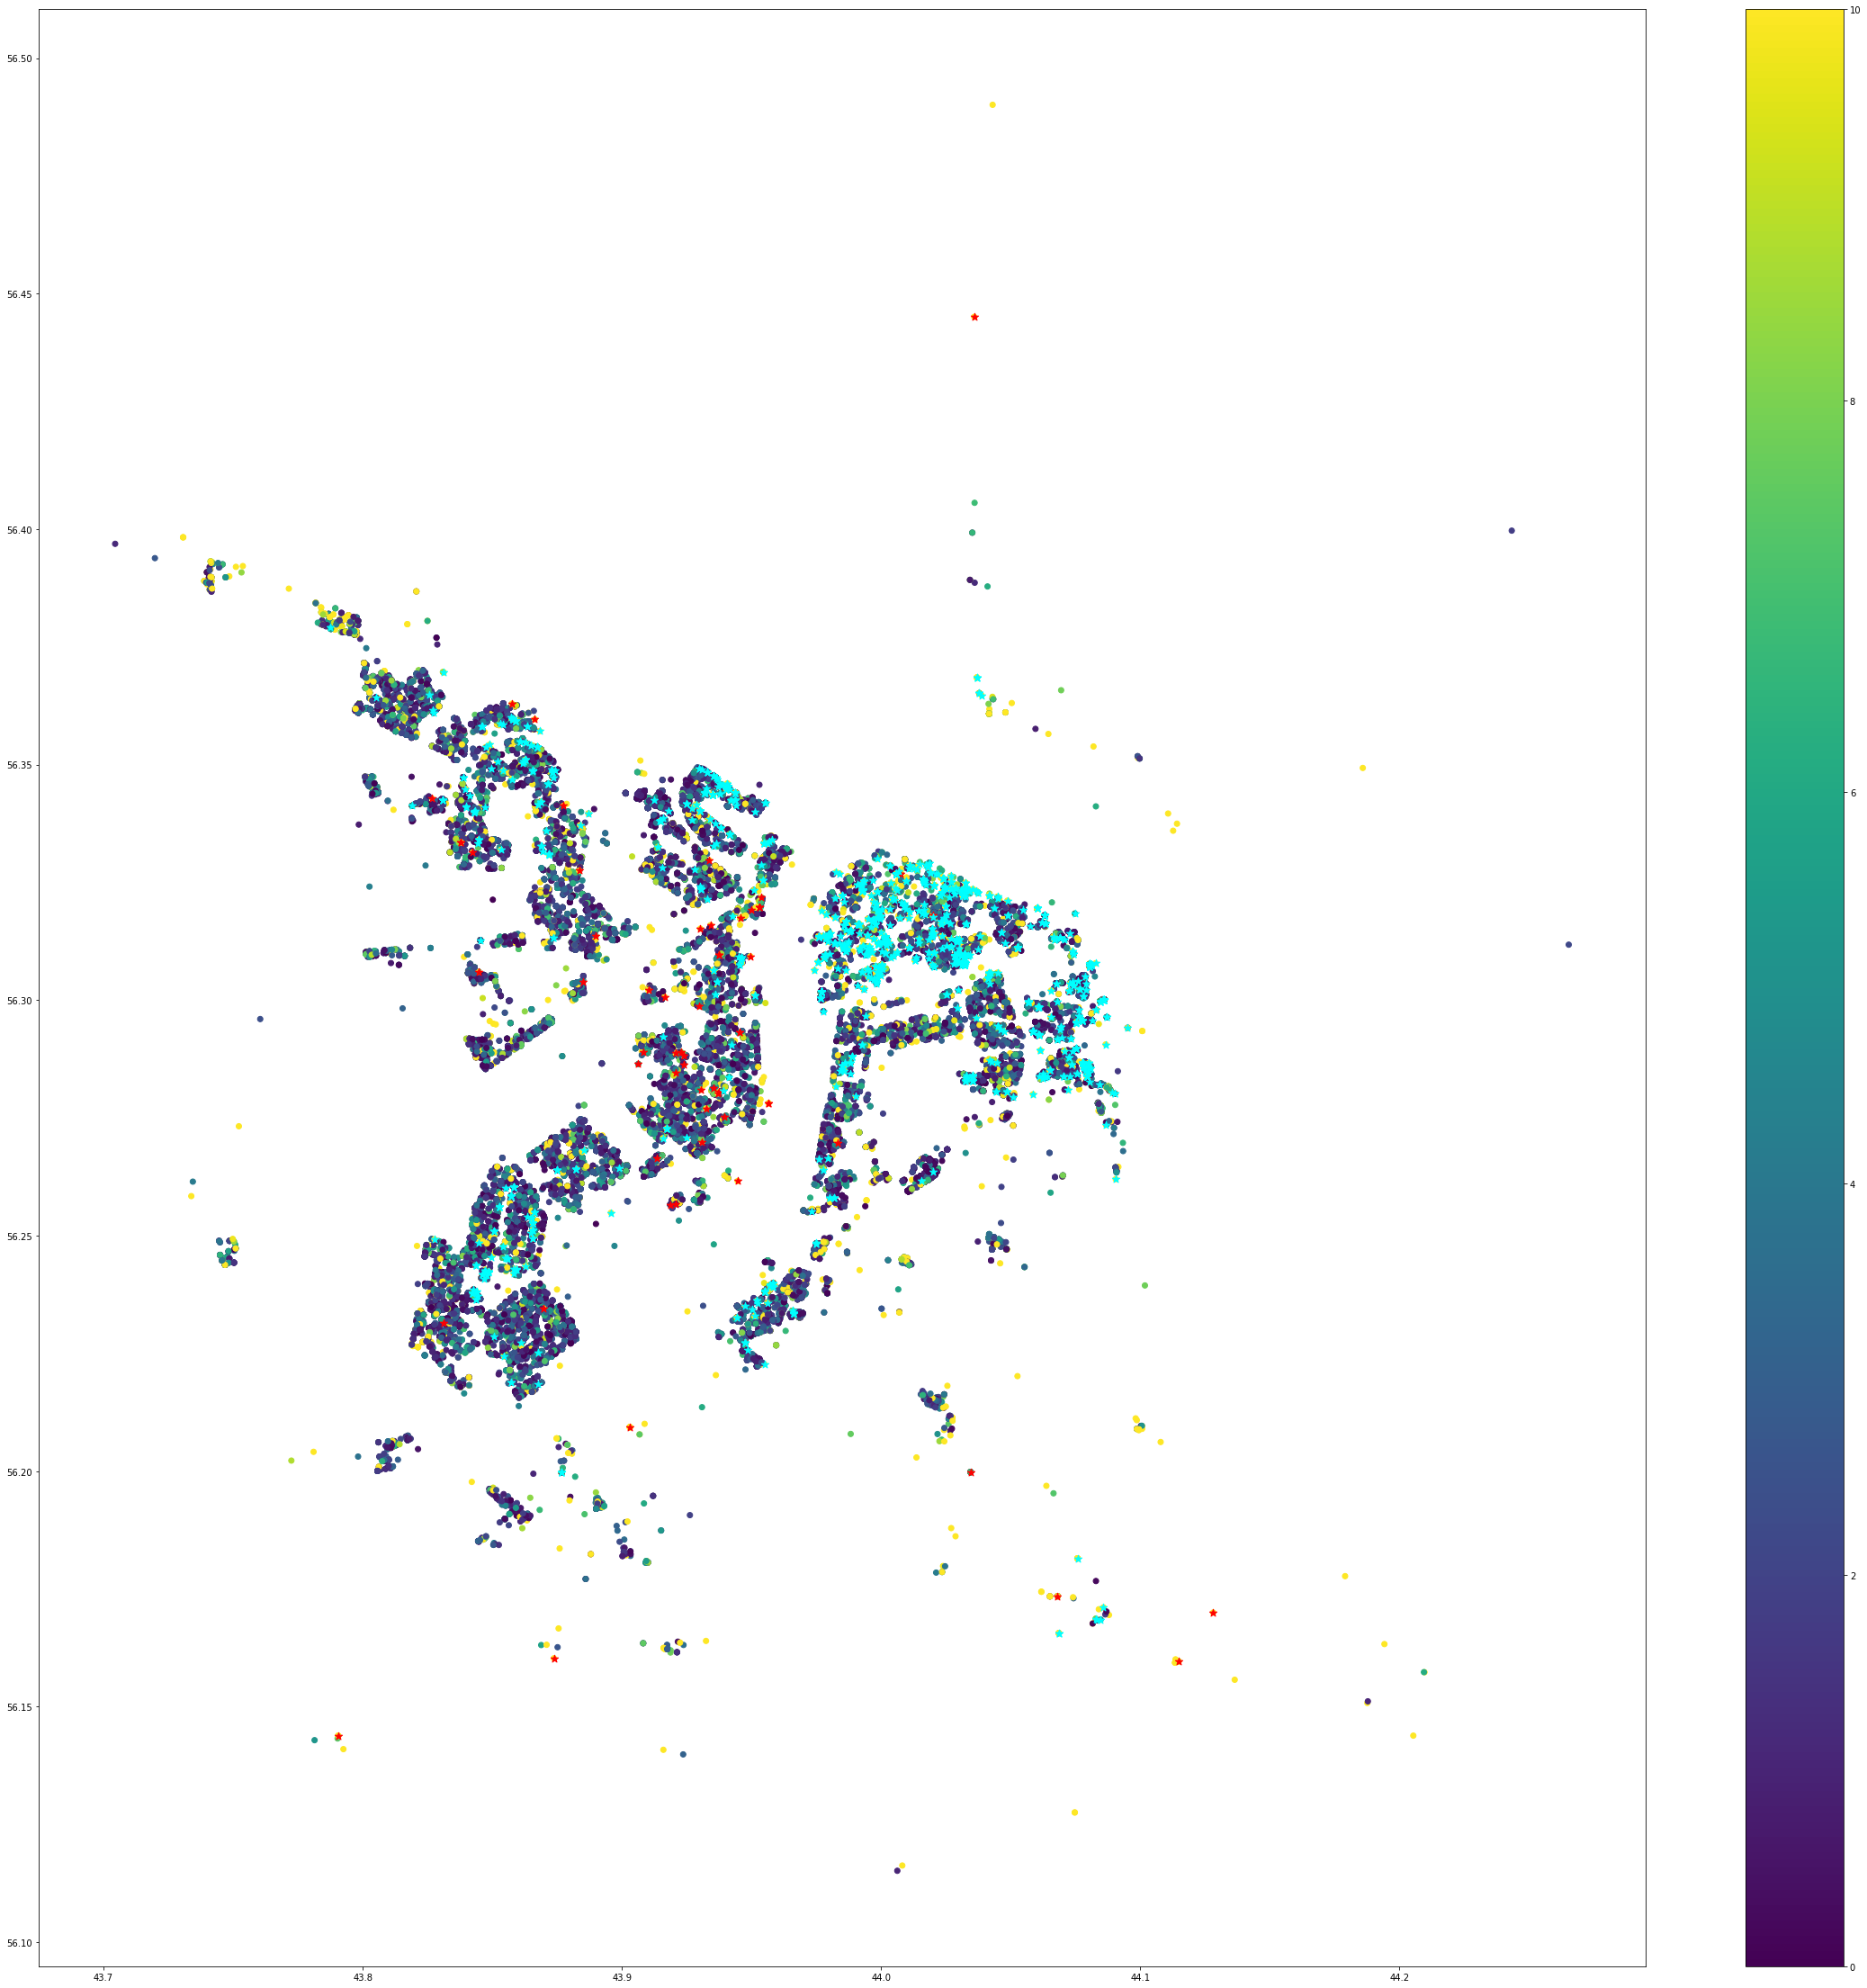

               type       price  longitude   latitude  total_square  \
29         Вторичка   5500000.0  44.032136  56.307566         60.00   
140        Вторичка   8600000.0  43.943823  56.344062        114.00   
339        Вторичка  10300000.0  44.074195  56.303107        121.00   
352        Вторичка   5100000.0  44.030187  56.312879         80.00   
401        Вторичка   5600000.0  43.857243  56.258473         80.00   
421     Новостройка  12599999.0  44.031425  56.322193        142.00   
424        Вторичка  11999999.0  44.061511  56.289320        230.00   
425        Вторичка   5900000.0  43.982208  56.321646         92.10   
495     Новостройка   5450640.0  43.998366  56.303844        104.82   
520        Вторичка   5490000.0  43.850479  56.250917         79.70   
585        Вторичка   8100000.0  44.065069  56.285079         93.50   
686        Вторичка   6200000.0  43.848925  56.354243        104.50   
690        Вторичка  11000000.0  44.082839  56.168685        180.00   
699   

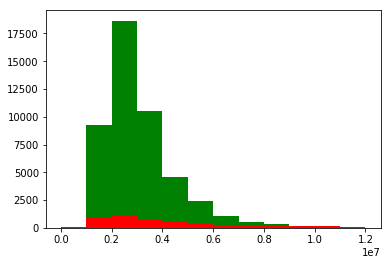

Плохие  примеры [  67.  904. 1057.  763.  621.  426.  286.  139.  141.  152.  122.  106.]
Хорошие примеры [  116.  9261. 18647. 10498.  4611.  2447.  1082.   521.   321.   195.
   122.   106.]
Отношение       [ 1.73134328 10.24446903 17.64143803 13.75884666  7.42512077  5.74413146
  3.78321678  3.74820144  2.27659574  1.28289474  1.          1.        ]


In [4]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 10 );

plt.figure(figsize=(40,40))
plt.scatter (x, y, c=c  )
plt.colorbar()

mask = ( Y_values < 1e6 ) & ( Y_relErr > 10 )
x_low = X_values[mask,0]; y_low = X_values[mask,1]; c_low = 'red'
print( x_low.size , y_low.size  )
plt.scatter (x_low, y_low, c=c_low, marker="*", s=75  )

mask = ( Y_values > 5e6 ) & ( Y_relErr > 10 )
x_high = X_values[mask,0]; y_high = X_values[mask,1]; c_high = 'aqua'
plt.scatter (x_high, y_high, c=c_high, marker="*", s=75  )
print( x_high.size, y_high.size )
plt.show    ()

print( allDataFrame[ mask ] )

threshold = 10
mask = Y_relErr >  threshold
badTestDataValues = testDataFrame[ mask ].price.values
mask = Y_relErr <= threshold
goodTestDataValues = testDataFrame[ mask ].price.values

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.]
bins = [i * 1e6 for i in bins]

n = plt.hist([badTestDataValues, goodTestDataValues], bins=bins, histtype='barstacked', color=['red','green'], label = ['bad', 'good'])
plt.show()

print('Плохие  примеры', n[0][0] )
print('Хорошие примеры', n[0][1] )
print('Отношение      ', n[0][1]/n[0][0])

In [5]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.001
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.001
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

BASE record
type                Вторичка
price                2.8e+06
longitude             43.995
latitude             56.3139
total_square             103
living_square             60
kitchen_square            15
number_of_rooms            3
floor_number               6
number_of_floors           8
building_type               
Name: 39464, dtype: object
CLOSEST record
type                 Вторичка
price                1.52e+06
longitude             43.9948
latitude              56.3139
total_square               34
living_square            16.5
kitchen_square            7.5
number_of_rooms             1
floor_number                2
number_of_floors            5
building_type       Кирпичный
Name: 1133, dtype: object
CLOSEST record
type                   Вторичка
price               8.14014e+06
longitude               43.9948
latitude                56.3139
total_square                 97
living_square                57
kitchen_square               15
number_of_rooms               2


CLOSEST record
type                 Вторичка
price                5.79e+06
longitude             43.9948
latitude              56.3139
total_square               80
living_square              12
kitchen_square             46
number_of_rooms             3
floor_number                2
number_of_floors            3
building_type       Кирпичный
Name: 82395, dtype: object
CLOSEST record
type                 Вторичка
price                1.85e+06
longitude             43.9948
latitude              56.3139
total_square               32
living_square              18
kitchen_square              6
number_of_rooms             1
floor_number                1
number_of_floors            5
building_type       Панельный
Name: 86377, dtype: object
CLOSEST record
type                 Вторичка
price                 1.7e+06
longitude             43.9948
latitude              56.3139
total_square               38
living_square              28
kitchen_square              5
number_of_rooms             2
f

CLOSEST record
type                  Вторичка
price                 4.85e+06
longitude              43.9514
latitude                 56.34
total_square                67
living_square               35
kitchen_square              12
number_of_rooms              2
floor_number                10
number_of_floors            17
building_type       Монолитный
Name: 83234, dtype: object
CLOSEST record
type                Вторичка
price               5.69e+06
longitude            43.9514
latitude               56.34
total_square            75.4
living_square             38
kitchen_square          12.5
number_of_rooms            2
floor_number              13
number_of_floors          17
building_type               
Name: 84779, dtype: object
CLOSEST record
type                Вторичка
price               6.95e+06
longitude            43.9514
latitude               56.34
total_square              76
living_square             38
kitchen_square            17
number_of_rooms            2
floor_num

CLOSEST record
type                 Вторичка
price                2.45e+06
longitude             43.9162
latitude              56.1625
total_square               90
living_square              52
kitchen_square             12
number_of_rooms             3
floor_number                4
number_of_floors            6
building_type       Кирпичный
Name: 24053, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude             43.9162
latitude              56.1625
total_square               82
living_square              46
kitchen_square             12
number_of_rooms             3
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 34841, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude             43.9162
latitude              56.1625
total_square             70.4
living_square              49
kitchen_square             12
number_of_rooms             3
f

CLOSEST record
type                Вторичка
price               2.23e+06
longitude            43.8057
latitude             56.2001
total_square              47
living_square             30
kitchen_square             6
number_of_rooms            2
floor_number               5
number_of_floors           5
building_type               
Name: 67149, dtype: object
CLOSEST record
type                Вторичка
price               2.15e+06
longitude            43.8057
latitude             56.2001
total_square              48
living_square             30
kitchen_square             6
number_of_rooms            2
floor_number               3
number_of_floors           5
building_type               
Name: 67370, dtype: object
CLOSEST record
type                Вторичка
price               1.85e+06
longitude            43.8057
latitude             56.2001
total_square              38
living_square             17
kitchen_square            10
number_of_rooms            1
floor_number               2
nu

CLOSEST record
type                 Вторичка
price                 4.5e+06
longitude             43.8542
latitude              56.3586
total_square             58.4
living_square              30
kitchen_square           11.5
number_of_rooms             2
floor_number                3
number_of_floors           10
building_type       Кирпичный
Name: 46422, dtype: object
CLOSEST record
type                Вторичка
price                6.3e+06
longitude            43.8542
latitude             56.3586
total_square              79
living_square             68
kitchen_square            11
number_of_rooms            3
floor_number               2
number_of_floors          10
building_type               
Name: 64304, dtype: object
CLOSEST record
type                Вторичка
price               2.89e+06
longitude            43.8542
latitude             56.3586
total_square              40
living_square             19
kitchen_square             9
number_of_rooms            1
floor_number        

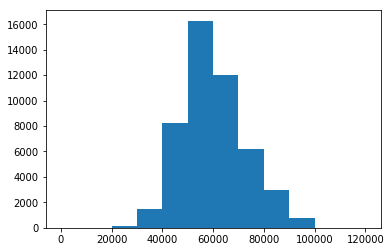

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

import matplotlib.pyplot as plt

bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000]

pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
pricePerSquareValues = pricePerSquare.values

plt.hist(  pricePerSquareValues, bins=bins )
plt.show()
